In [1]:
# Julia version of the code for nonlinear filtering
# for quasi-linear models
# Author: Takeki Sunakawa
# Mail: takeki.sunakawa@gmail.com

using DelimitedFiles
using Random
using Distributions # not in CoCalc
using StatsBase # not in CoCalc
using Plots
using KernelDensity
include("linsol.jl")
include("model.jl")

pdfy (generic function with 1 method)

In [3]:
function PF2(m, para, rng, N, yt, resample)
# explicit loop for # of particles
    adjusted = 0
    
    # housekeeping
    ne = 3
    ns = 10
    T    = size(yt,1)
    
    adjusted_proposal = zeros(T)
    adjusted_proposal_std = ones(T)
    adjusted_proposal_mu = zeros(T,ne)
    if (adjusted==1)
        adjusted_proposal[104] = 1
        adjusted_proposal_std[104] = 1.2 # it does not matter much?
        adjusted_proposal_mu[104,2] = -3.0 # -2.0 works poorer
    end

    sigma_R = para[11]
    sigma_g = para[12]
    sigma_z = para[13]
    sqrtS2 = zeros(3,3)
    sqrtS2[1,1] = sigma_g
    sqrtS2[2,2] = sigma_z
    sqrtS2[3,3] = sigma_R
    
    # matrix for store
    all_s_up  = zeros(T,ns,N) # resampled
    lik       = zeros(T,1)
    Neff      = zeros(T,1)

    # initialization
    s_up = zeros(ns,N)
    s_fore = zeros(ns,N)

    shocks = randn(rng,ne,N)
    for j=2:N
        s_up[:,j] = g(m,para,s_up[:,j-1],sqrtS2*shocks[:,j])
    end

    shocks = randn(rng,ne,N)
    for j=1:N
        s_fore[:,j] = g(m,para,s_up[:,j],sqrtS2*shocks[:,j])
    end

    s_up = copy(s_fore)

    density = ones(N,1)
    weights = ones(N,1)

    yy = zeros(3,1)

    # Rest of Steps
    for tt=1:1:T

        yy[:,1] = yt[tt,:]'
        shocks = randn(rng,ne,N)

        if (adjusted==1 && adjusted_proposal[tt]==1)
            
            is_sampling_std = adjusted_proposal_std[tt]
            is_sampling_mu = adjusted_proposal_mu[tt,:]
            shocks = is_sampling_std*shocks + repeat(is_sampling_mu',N)'
            
        end
            
        for i=1:N
        
            # Propagate
            s_fore[:,i] = g(m,para,s_up[:,i],sqrtS2*shocks[:,i])

            # Un-normalized weights (naive boostrap particle filter)
            temp = pdfy(para,yy,s_fore[:,i],s_up[:,i])
            density[i] = temp[1]

            # Store results
            all_s_up[tt,:,i] = s_up[:,i]
            
        end

        if (adjusted==1 && adjusted_proposal[tt]==1)
            
            for i=1:N

                kap = is_sampling_std^ne * exp(-0.5*shocks[:,i]'*shocks[:,i]) / exp(-0.5*(shocks[:,i].-is_sampling_mu)'*(shocks[:,i].-is_sampling_mu))
                density[i] = density[i]*kap
                
            end
            
        end        
        
        lik[tt,1]        = log(mean(density.*weights))
        
        # Normalize weights
        weights = (density.*weights)./(mean(density.*weights))

        # Effective sample size
        Neff[tt,1] = (N^2)/sum(weights.^2)

        if resample == 1 && Neff[tt,1] <= N/2
            s_up = s_fore[:,sample(rng,collect(1:N),Weights(weights[:,1]),N,replace=true)] # Resampling if ESS falls below a threshold
            weights = ones(N,1)
        else
            s_up = copy(s_fore)
        end    

    end

    return lik, all_s_up, Neff
end

PF2 (generic function with 1 method)

In [4]:
yt = readdlm("us.txt")
para = [2.09,0.98,2.25,0.65,0.34,3.16,0.51,0.81,0.98,0.93,0.19,0.65,0.24]
T1,T0 = model_solution(para)
A,B,H,R,S2,Phi = sysmat(T1,T0,para)

@time liki, measurepredi, statepredi, varstatepredi = KF(A,B,H,R,S2,Phi,yt);

  0.813976 seconds (2.41 M allocations: 117.434 MiB, 5.53% gc time)


In [5]:
m = new_model()
@time solve(m,para)

rng = MersenneTwister(1234)
N = 40000 # number of particles 
@time lik, all_s_up, Neff = PF2(m, para, rng, N, yt, 1);

  0.862609 seconds (2.68 M allocations: 162.693 MiB, 6.17% gc time)
  5.129501 seconds (47.76 M allocations: 6.627 GiB, 22.44% gc time)


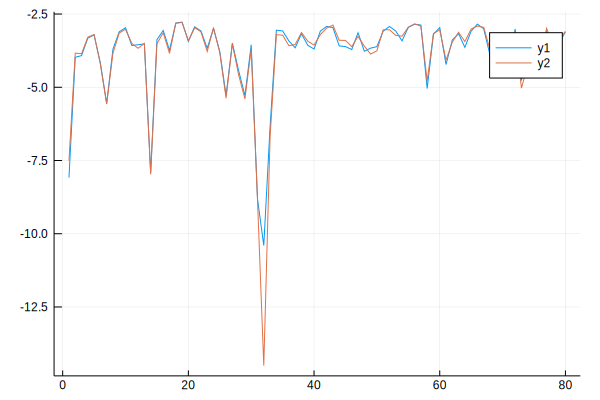

In [6]:
plot(liki)
plot!(lik)

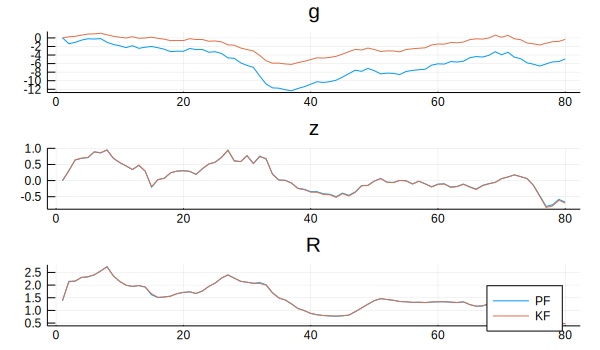

In [7]:
T = 80

rA      = para[5]
piA     = para[6]
gammaQ  = para[7]
rstar = gammaQ+piA/4+rA/4    

y1 = [mean(all_s_up[:,8,:],dims=2), statepredi[1:end-1,5]]
y2 = [mean(all_s_up[:,9,:],dims=2), statepredi[1:end-1,6]]
y3 = [mean(all_s_up[:,5,:],dims=2).+rstar, statepredi[1:end-1,3].+rstar]
plot(
    plot([1:T],y1,title="g",legend=false),
    plot([1:T],y2,title="z",legend=false),
    plot([1:T],y3,title="R"),
    layout=(3,1),size=(600,350),label=["PF" "KF"] #,legend=false
)

40000


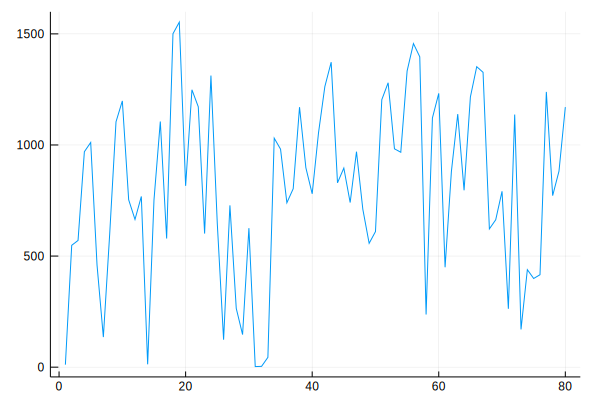

In [8]:
println(N)
plot(Neff,legend=false)

In [14]:
liki, measurepredi, statepredi, varstatepredi = KF(A,B,H,R,S2,Phi,yt)

N_opts = [1000,10000]

Nrep = 100

lik_store = zeros(Nrep, size(N_opts)[1])

for r = 1:Nrep
    
    for n = 1:size(N_opts)[1]
        
        rng = MersenneTwister(1234+n)
        N = N_opts[n]
        
        @time lik, all_s_up, Neff = PF2(m, para, rng, N, yt, 1)
        
        lik_store[r,n] = sum(lik) - sum(liki)
        
    end
    
end

  0.090881 seconds (1.14 M allocations: 167.197 MiB, 18.24% gc time)
  0.969696 seconds (11.42 M allocations: 1.632 GiB, 21.38% gc time)
  0.086767 seconds (1.14 M allocations: 167.197 MiB, 13.66% gc time)
  0.960016 seconds (11.42 M allocations: 1.632 GiB, 20.98% gc time)
  0.084061 seconds (1.14 M allocations: 167.197 MiB, 13.65% gc time)
  0.972421 seconds (11.42 M allocations: 1.632 GiB, 20.95% gc time)
  0.083272 seconds (1.14 M allocations: 167.197 MiB, 13.92% gc time)
  1.003076 seconds (11.42 M allocations: 1.632 GiB, 20.33% gc time)
  0.083817 seconds (1.14 M allocations: 167.197 MiB, 14.27% gc time)
  1.016419 seconds (11.42 M allocations: 1.632 GiB, 20.99% gc time)
  0.087627 seconds (1.14 M allocations: 167.197 MiB, 14.44% gc time)
  1.005446 seconds (11.42 M allocations: 1.632 GiB, 21.24% gc time)
  0.093330 seconds (1.14 M allocations: 167.197 MiB, 14.27% gc time)
  1.050046 seconds (11.42 M allocations: 1.632 GiB, 20.86% gc time)
  0.091139 seconds (1.14 M allocations: 1

  0.099817 seconds (1.14 M allocations: 167.197 MiB, 14.70% gc time)
  1.164885 seconds (11.42 M allocations: 1.632 GiB, 21.13% gc time)
  0.103278 seconds (1.14 M allocations: 167.197 MiB, 15.45% gc time)
  1.163562 seconds (11.42 M allocations: 1.632 GiB, 21.19% gc time)
  0.092565 seconds (1.14 M allocations: 167.197 MiB, 14.21% gc time)
  1.112304 seconds (11.42 M allocations: 1.632 GiB, 20.90% gc time)
  0.103908 seconds (1.14 M allocations: 167.197 MiB, 14.87% gc time)
  1.140558 seconds (11.42 M allocations: 1.632 GiB, 21.29% gc time)
  0.095095 seconds (1.14 M allocations: 167.197 MiB, 14.29% gc time)
  1.233845 seconds (11.42 M allocations: 1.632 GiB, 21.02% gc time)
  0.111858 seconds (1.14 M allocations: 167.197 MiB, 13.47% gc time)
  1.517537 seconds (11.42 M allocations: 1.632 GiB, 23.95% gc time)
  0.102808 seconds (1.14 M allocations: 167.197 MiB, 14.77% gc time)
  1.193523 seconds (11.42 M allocations: 1.632 GiB, 22.18% gc time)
  0.103647 seconds (1.14 M allocations: 1

In [15]:
size(lik_store)

(100, 2)

In [ ]:
kd1 = kde(lik_store[:,1])
# kd2 = kde(lik_store[:,2])
# kd3 = kde(lik_store[:,3])

plot(kd1.x,kd1.density)
# plot!(kd2.x,kd2.density)
# plot!(kd3.x,kd3.density)

In [ ]:
T1,T0 = model_solution(para)

rA      = para[5]
piA     = para[6]
gammaQ  = para[7]
rho_R   = para[8]
rho_g   = para[9]
rho_z   = para[10]
sigma_R = para[11]
sigma_g = para[12]
sigma_z = para[13]

bet  = 1/(1+rA/400)
rstar = gammaQ+piA/4+rA/4

# set bounds
rnmin = -m.pctrn
rnmax = m.pctrn
gmin = -m.mg*sigma_g/sqrt(1-rho_g^2)
gmax = m.mg*sigma_g/sqrt(1-rho_g^2)
zmin = -m.mz*sigma_z/sqrt(1-rho_z^2)
zmax = m.mz*sigma_z/sqrt(1-rho_z^2)
rmin = -m.mr*sigma_R
rmax = m.mr*sigma_R

rngrid = collect(LinRange(rnmin,rnmax,101))
ggrid = collect(LinRange(gmin,gmax,101))
zgrid = collect(LinRange(zmin,zmax,101))
rgrid = collect(LinRange(rmin,rmax,101))

rnvec_lin = zeros(101)
pivec_lin = zeros(101)
yvec_lin  = zeros(101)
cvec_lin  = zeros(101)
rnvec_nolin = zeros(101)
pivec_nolin = zeros(101)
yvec_nolin  = zeros(101)
cvec_nolin  = zeros(101)

for i = 1:101
    
    rnpast = rngrid[i]
#     rnpast = 0
#     gnow = ggrid[i]
    gnow = 0 #gmax
#     znow = zgrid[i]
    znow = zmin
#     rnow = rgrid[i]
    rnow = rmin

    endogvarm = zeros(8)
    endogvarm[3] = rnpast
    shocks = zeros(3)
    shocks[1] = znow
    shocks[2] = gnow
    shocks[3] = rnow
    endogvar = T1*endogvarm + T0*shocks
    
    rnvec_lin[i] = endogvar[3]
    pivec_lin[i] = endogvar[2]
    yvec_lin[i] = endogvar[1]    
    
    endogvarm = [rnpast 0 0 0 0 0 0 0 0 0]
    shocks = [gnow znow rnow]
    endogvar = decr(endogvarm,shocks,para,m.slopecon,m.coeffcn,m.coeffpn,m.coeffcb,m.coeffpb,m.np,m.ns)
    
    rnvec_nolin[i] = endogvar[5]
    pivec_nolin[i] = endogvar[3]
    yvec_nolin[i] = endogvar[4]
    cvec_nolin[i] = endogvar[2]
    
end

plot(
    plot(rngrid,[rnvec_nolin rnvec_lin],title="Policy Rate"),
    plot(rngrid,[pivec_nolin pivec_lin],title="Inflation"),
    plot(rngrid,[yvec_nolin yvec_lin],title="Output Gap"),
    layout=(3,1),size=(800,600),label=["nolin" "lin"]
)
